In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
class LNN:
    def __init__(self, N, v = None, w = None, sigmaS = 1., sigmaI = 1., sigmaG = 1., nonlinearity = None):
        self.N = N
        if v is None:
            self.v = 0
        else:
            self.v = v
        
        if w is None:
            self.w = 0
        else:
            self.w = w
        
        if nonlinearity is None:
            self.nonlinearity = self.squared
        else:
            self.nonlinearity = nonlinearity
        
        self.sigmaS = sigmaS
        self.sigmaI = sigmaI
        self.sigmaG = sigmaG
    
    def squared(self,x):
        return x**2

    def simulate(self,trials):
        s = np.random.normal(loc = 0., scale = sigmaG, size = trials)
        injected_noise = np.random.normal(loc = 0., scale = sigmaI, size = trials)
        private_noise = np.random.normal(loc = 0., scale = sigmaG, size = (self.N, trials))
        l = np.outer(self.v, s) + np.outer(self.w, injected_noise) + private_noise
        r = self.nonlinearity(l)
        return r
    
    def mutual(self):
        v2 = np.sum(self.v**2)
        w2 = np.sum(self.w**2)
        vw = np.sum(v * w)
        sigma_inj = self.sigmaG**2 + self.sigmaI**2 * w2
        sigma_stim = self.sigmaG**2 + self.sigmaS**2 * v2
        kappa = sigma_inj * sigma_stim - self.sigmaI**2 * self.sigmaS**2 * vw**2
        I1 = 0.5 * np.log(kappa/(self.sigmaG**2 * sigma_inj))
        
        w_outer = np.outer(w, w)
        v_outer = np.outer(v, v)
        wv_outer = np.outer(w, v)
        
        B = -(self.sigmaI**2 * self.sigmaS**2 * vw)**2/(2 * self.sigmaG**2 * kappa * sigma_inj) * w_outer \
            + (self.sigmaI * self.sigmaS**2 * vw)/(kappa * self.sigmaG**2) * wv_outer \
            - (self.sigmaS**2 * sigma_inj)/(2 * self.sigmaG**2 * kappa) * v_outer
        A = 1./(2 * self.sigmaG**2) * np.identity(self.N) - sigma_stim/(2 * self.sigmaG**2 * kappa) * w_outer \
            + (self.sigmaI * self.sigmaS**2 * vw)/(kappa * self.sigmaG**2) * wv_outer \
            - (self.sigmaS**2 * sigma_inj)/(2 * self.sigmaG**2 * kappa) * v_outer
        
        I2 = np.trace(np.dot(B, np.linalg.inv(A)))/(self.sigmaG**(self.N - 2.) * 2**(self.N/2.) * np.sqrt(kappa * np.linalg.det(A)))
        
        C = self.sigmaG**2 * kappa * sigma_inj * (self.sigmaG**2 * v2 + self.sigmaI**2 * (v2 * w2 - vw**2))
        D = 1./(2 * self.sigmaG**2) * np.identity(self.N) \
            -(1./(2 * self.sigmaG**2 * kappa)) * (-sigma_stim * w_outer + 2 * self.sigmaI * self.sigmaS**2 * vw * wv_outer - self.sigmaS**2 * sigma_inj * v_outer)
        gamma = (2 * self.sigmaG**2 + self.sigmaS**2 * v2) * sigma_stim - self.sigmaI**2 * self.sigmaS**2 * vw**2
        E = gamma * (-self.sigmaI**2 * w_outer + 2 * self.sigmaI * vw * wv_outer - sigma_inj**2 * v_outer)
        I3 = -self.sigmaS**2/(2 * 2**(self.N/2) * self.sigmaG**self.N * kappa**(2.5) * sigma_inj * np.sqrt(np.linalg.det(D))) \
            * (C + np.trace(np.dot(E, np.linalg.inv(D))))
        return I1 + I2 + I3
        

In [16]:
ns = np.arange(200)
muts = np.zeros(ns.shape)

In [17]:
for idx, n in enumerate(ns):
    v = np.ones(n)
    w = np.ones(n)
    lnn = LNN(n, v = v, w = w)
    muts[idx] = lnn.mutual()

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in long_scalars
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


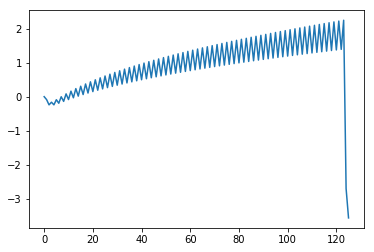

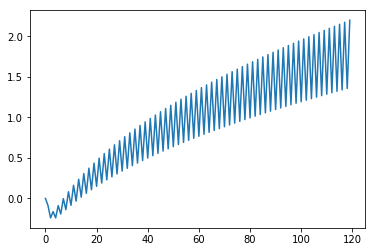

In [18]:
plt.plot(ns, muts)
plt.show()
plt.plot(ns[:120], muts[:120])
plt.show()

In [29]:
ns2 = np.arange(0, 200, 2)
muts2 = np.zeros(ns2.shape)
for idx, n in enumerate(ns2):
    v = np.ones(n)
    w = np.concatenate((np.ones(n/2), 2 * np.ones(n/2)))
    lnn = LNN(n, v = v, w = w)
    muts2[idx] = lnn.mutual()

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in long_scalars
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


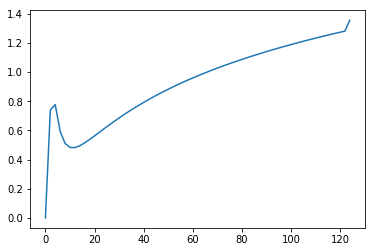

In [30]:
plt.plot(ns2, muts2)